In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "IGH_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-AB-RTX-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-Myositis-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-Vasculitis-IGH_HUMAN-after-reassignment.csv']

In [3]:
pt_file="20200727_MSrun039_pt_table.csv"
run = "run39"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
excel_file = run + "-similarity-" + celltype + ".xlsx"
print("Outfile:", plotfile)

Outfile: run39-similarity-IGH_HUMAN.pdf


## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,AB-RTX114-Bu_S14,ATGCATGC,CARHRGPFSYYCSMDVWGQGTPVT,578,331,IGHV3-48,IGHJ6,13,0.022491,5.231243,4.825776
1,AB-RTX114-Bu_S14,ATGCATGC,CARAGAEGWFDPWGQGTLVT,522,269,IGHV3-11,IGHJ5,3,0.005747,4.724409,3.921854
2,AB-RTX114-Bu_S14,ATGCATGC,CARDQGYSYGSHYFDYWGQGTLVT,399,253,IGHV3-30,IGHJ4,15,0.037594,3.611187,3.688584
3,AB-RTX114-Bu_S14,ATGCATGC,CARYVAYSSDSWGQGTLVT,316,173,IGHV3-23,"IGHJ4,IGHJ5",7,0.022152,2.859987,2.522234
4,AB-RTX114-Bu_S14,ATGCATGC,CAKRAYSGYSAMDVWGQGTTVT,240,191,IGHV3-33,IGHJ6,2,0.008333,2.172142,2.784662


In [6]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
152982,VC018V1-2-SUB-U_S82,CARGFLENSFDLWGQGTLVT,2919,186,46,0.015759,4.461870,3.348938
152635,VC018V1-2-SUB-U_S82,CAKGYNDSAYWGQGTLVT,2323,148,2343,1.008610,3.550848,2.664746
152475,VC018V1-2-SUB-U_S82,CAGWASANPWGQGTLVT,2211,141,38,0.017187,3.379649,2.538711
153017,VC018V1-2-SUB-U_S82,CARGGMTTSWYWVYWGQGTLVT,1986,138,67,0.033736,3.035722,2.484696
153302,VC018V1-2-SUB-U_S82,CASGWYSHDYWGQGTLVT,1456,15,11,0.007555,2.225585,0.270076


## Import patient table

In [7]:
pt = pd.read_csv(pt_file, sep=";")
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Samples order,Sample_ID,Sample name,MID,Project,Species,Chain,Patient,SampleInfo,Group,UMI,HEK
0,S1,N701_S502,A234-Bk2,NaN,VDJmouse,mouse,BCRk,A10Q2,Blood-day0,VERA-Naive,no,yes
1,S2,N702_S502,A235-Bk2,NaN,VDJmouse,mouse,BCRk,A10Q3,Blood-day0,VERA-Naive,no,yes
2,S3,N703_S502,A236-Bk2,NaN,VDJmouse,mouse,BCRk,A10Q4,Blood-day0,VERA-Naive,no,yes
3,S4,N704_S502,A237-Bk2,NaN,VDJmouse,mouse,BCRk,A10Q1,BM-day0,VERA-Naive,no,yes
4,S5,N705_S502,A241-Bk2,NaN,VDJmouse,mouse,BCRk,A10Q1,Spleen-day0,VERA-Naive,no,yes


In [8]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample name'], pt['Samples order'])]
pt = pt[["Sample","Patient"]]

In [9]:
pt.head()

,Sample,Patient
0,A234-Bk2_S1,A10Q2
1,A235-Bk2_S2,A10Q3
2,A236-Bk2_S3,A10Q4
3,A237-Bk2_S4,A10Q1
4,A241-Bk2_S5,A10Q1


## Merge clones with pt

In [10]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,VC018V1-2-SUB-U_S82,CARGFLENSFDLWGQGTLVT,2919,186,46,0.015759,4.461870,3.348938,VC018V1
1,VC018V1-2-SUB-U_S82,CAKGYNDSAYWGQGTLVT,2323,148,2343,1.008610,3.550848,2.664746,VC018V1
2,VC018V1-2-SUB-U_S82,CAGWASANPWGQGTLVT,2211,141,38,0.017187,3.379649,2.538711,VC018V1
3,VC018V1-2-SUB-U_S82,CARGGMTTSWYWVYWGQGTLVT,1986,138,67,0.033736,3.035722,2.484696,VC018V1
4,VC018V1-2-SUB-U_S82,CASGWYSHDYWGQGTLVT,1456,15,11,0.007555,2.225585,0.270076,VC018V1


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient                            10-01-0003                                  \
Sample                       AB-RTX135-Bu_S43 AB-RTX136-Bu_S52 AB-RTX56-Bu_S9   
cdr3pep                                                                         
AAAAGSDGFDIWGQGTMVT                       0.0              9.0            0.0   
AAAAGSDGFDIWGQGTTVT                       1.0              0.0            0.0   
AAVT                                      0.0              0.0            0.0   
ASRGYSSGWYSYYYYGMDVWGQGTTVT               0.0              0.0            0.0   
ATFTYYYGSGSYSVLDAFDIWGQGTMVT              0.0              0.0            0.0   

Patient                            10-01-0007                  \
Sample                       AB-RTX138-Bu_S53 AB-RTX58-Bu_S10   
cdr3pep                                                         
AAAAGSDGFDIWGQGTMVT                       0.0             0.0   
AAAAGSDGFDIWGQGTTVT                       0.0             0.0   
AAVT                                      0.0             0.0   
ASRGYSSGWYSYYYYGMDVWGQGTTVT               0.0             0.0   
ATFTYYYGSGSYSVLDAFDIWGQGTMVT              0.0             0.0   

Patient                            10-01-0012                   \
Sample                       AB-RTX114-Bu_S14 AB-RTX140-Bu_S54   
cdr3pep                                                          
AAAAGSDGFDIWGQGTMVT                       0.0              0.0   
AAAAGSDGFDIWGQGTTVT                       0.0              0.0   
AAVT                                      0.0              0.0   
ASRGYSSGWYSYYYYGMDVWGQGTTVT               0.0              0.0   
ATFTYYYGSGSYSVLDAFDIWGQGTMVT              0.0              0.0   

Patient                            10-02-0009                   \
Sample                       AB-RTX115-Bu_S15 AB-RTX116-Bu_S16   
cdr3pep                                                          
AAAAGSDGFDIWGQGTMVT                       0.0              0.0   
AAAAGSDGFDIWGQGTTVT                       0.0              0.0   
AAVT                                      0.0              0.0   
ASRGYSSGWYSYYYYGMDVWGQGTTVT               0.0              0.0   
ATFTYYYGSGSYSVLDAFDIWGQGTMVT              0.0              3.0   

Patient                                               ...          \
Sample                       AB-RTX141-Bu_S55         ...           
cdr3pep                                               ...           
AAAAGSDGFDIWGQGTMVT                       0.0         ...           
AAAAGSDGFDIWGQGTTVT                       0.0         ...           
AAVT                                      0.0         ...           
ASRGYSSGWYSYYYYGMDVWGQGTTVT               0.0         ...           
ATFTYYYGSGSYSVLDAFDIWGQGTMVT              0.0         ...           

Patient                                    MYO114                      \
Sample                       MYO114week52-B2H_S51 MYO114week52-B2_S62   
cdr3pep                                                                 
AAAAGSDGFDIWGQGTMVT                           0.0                 0.0   
AAAAGSDGFDIWGQGTTVT                           0.0                 0.0   
AAVT                                          0.0                 0.0   
ASRGYSSGWYSYYYYGMDVWGQGTTVT                   0.0                 0.0   
ATFTYYYGSGSYSVLDAFDIWGQGTMVT                  0.0                 0.0   

Patient                               MYO201          MYO202          MYO203  \
Sample                       E2134-17-B3_S70 E2134-39-B2_S71 E2208-34-B2_S72   
cdr3pep                                                                        
AAAAGSDGFDIWGQGTMVT                      0.0             0.0             0.0   
AAAAGSDGFDIWGQGTTVT                      0.0             0.0             0.0   
AAVT                                     0.0             0.0             0.0   
ASRGYSSGWYSYYYYGMDVWGQGTTVT              0.0             0.0             0.0   
ATFTYYYGSGSYSVLDAFDIWGQGTMVT             0.0             0.0             0

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                           10-01-0003                                  \
Sample                      AB-RTX135-Bu_S43 AB-RTX136-Bu_S52 AB-RTX56-Bu_S9   
Patient    Sample                                                              
10-01-0003 AB-RTX135-Bu_S43         1.000000         0.012768       0.004704   
           AB-RTX136-Bu_S52         0.012768         1.000000       0.006002   
           AB-RTX56-Bu_S9           0.004704         0.006002       1.000000   
10-01-0007 AB-RTX138-Bu_S53         0.000122         0.000000       0.000000   
           AB-RTX58-Bu_S10          0.000000         0.000000       0.000000   

Patient                           10-01-0007                       10-01-0012  \
Sample                      AB-RTX138-Bu_S53 AB-RTX58-Bu_S10 AB-RTX114-Bu_S14   
Patient    Sample                                                               
10-01-0003 AB-RTX135-Bu_S43         0.000122        0.000000         0.000000   
           AB-RTX136-Bu_S52         0.000000        0.000000         0.000361   
           AB-RTX56-Bu_S9           0.000000        0.000000         0.000449   
10-01-0007 AB-RTX138-Bu_S53         1.000000        0.014553         0.000000   
           AB-RTX58-Bu_S10          0.014553        1.000000         0.000000   

Patient                                            10-02-0009  \
Sample                      AB-RTX140-Bu_S54 AB-RTX115-Bu_S15   
Patient    Sample                                               
10-01-0003 AB-RTX135-Bu_S43              0.0         0.000000   
           AB-RTX136-Bu_S52              0.0         0.000060   
           AB-RTX56-Bu_S9                0.0         0.000064   
10-01-0007 AB-RTX138-Bu_S53              0.0         0.000000   
           AB-RTX58-Bu_S10               0.0         0.000000   

Patient                                                        \
Sample                      AB-RTX116-Bu_S16 AB-RTX141-Bu_S55   
Patient    Sample                                               
10-01-0003 AB-RTX135-Bu_S43         0.000000              0.0   
           AB-RTX136-Bu_S52         0.000372              0.0   
           AB-RTX56-Bu_S9           0.000342              0.0   
10-01-0007 AB-RTX138-Bu_S53         0.000000              0.0   
           AB-RTX58-Bu_S10          0.000000              0.0   

Patient                             ...                       MYO114  \
Sample                              ...         MYO114week52-B2H_S51   
Patient    Sample                   ...                                
10-01-0003 AB-RTX135-Bu_S43         ...                     0.000617   
           AB-RTX136-Bu_S52         ...                     0.000111   
           AB-RTX56-Bu_S9           ...                     0.000177   
10-01-0007 AB-RTX138-Bu_S53         ...                     0.000093   
           AB-RTX58-Bu_S10          ...                     0.000000   

Patient                                                  MYO201  \
Sample                      MYO114week52-B2_S62 E2134-17-B3_S70   
Patient    Sample                                                 
10-01-0003 AB-RTX135-Bu_S43            0.000254        0.000302   
           AB-RTX136-Bu_S52            0.000266        0.000000   
           AB-RTX56-Bu_S9              0.000277        0.000000   
10-01-0007 AB-RTX138-Bu_S53            0.000052        0.000439   
           AB-RTX58-Bu_S10             0.000000        0.000000   

Patient                              MYO202          MYO203         VC015V3  \
Sample                      E2134-39-B2_S71 E2208-34-B2_S72 VC015V3-2-B_S73   
Patient    Sample                                                             
10-01-0003 AB-RTX135-Bu_S43        0.000038        0.000000        0.000334   
           AB-RTX136-Bu_S52        0.000000        0.000034        0.000000   
           AB-RTX56-Bu_S9          0.000000        0.000107        0.000000   
10-01-0007 AB-RTX138-Bu_S53        0.000039        0.000000        0.000000   
 

In [13]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote run39-similarity-IGH_HUMAN.xlsx to disk


## Create a heatmap

In [14]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [15]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 7.668153010342849e-06
max value: 1.0
Wrote run39-similarity-IGH_HUMAN.pdf to disk


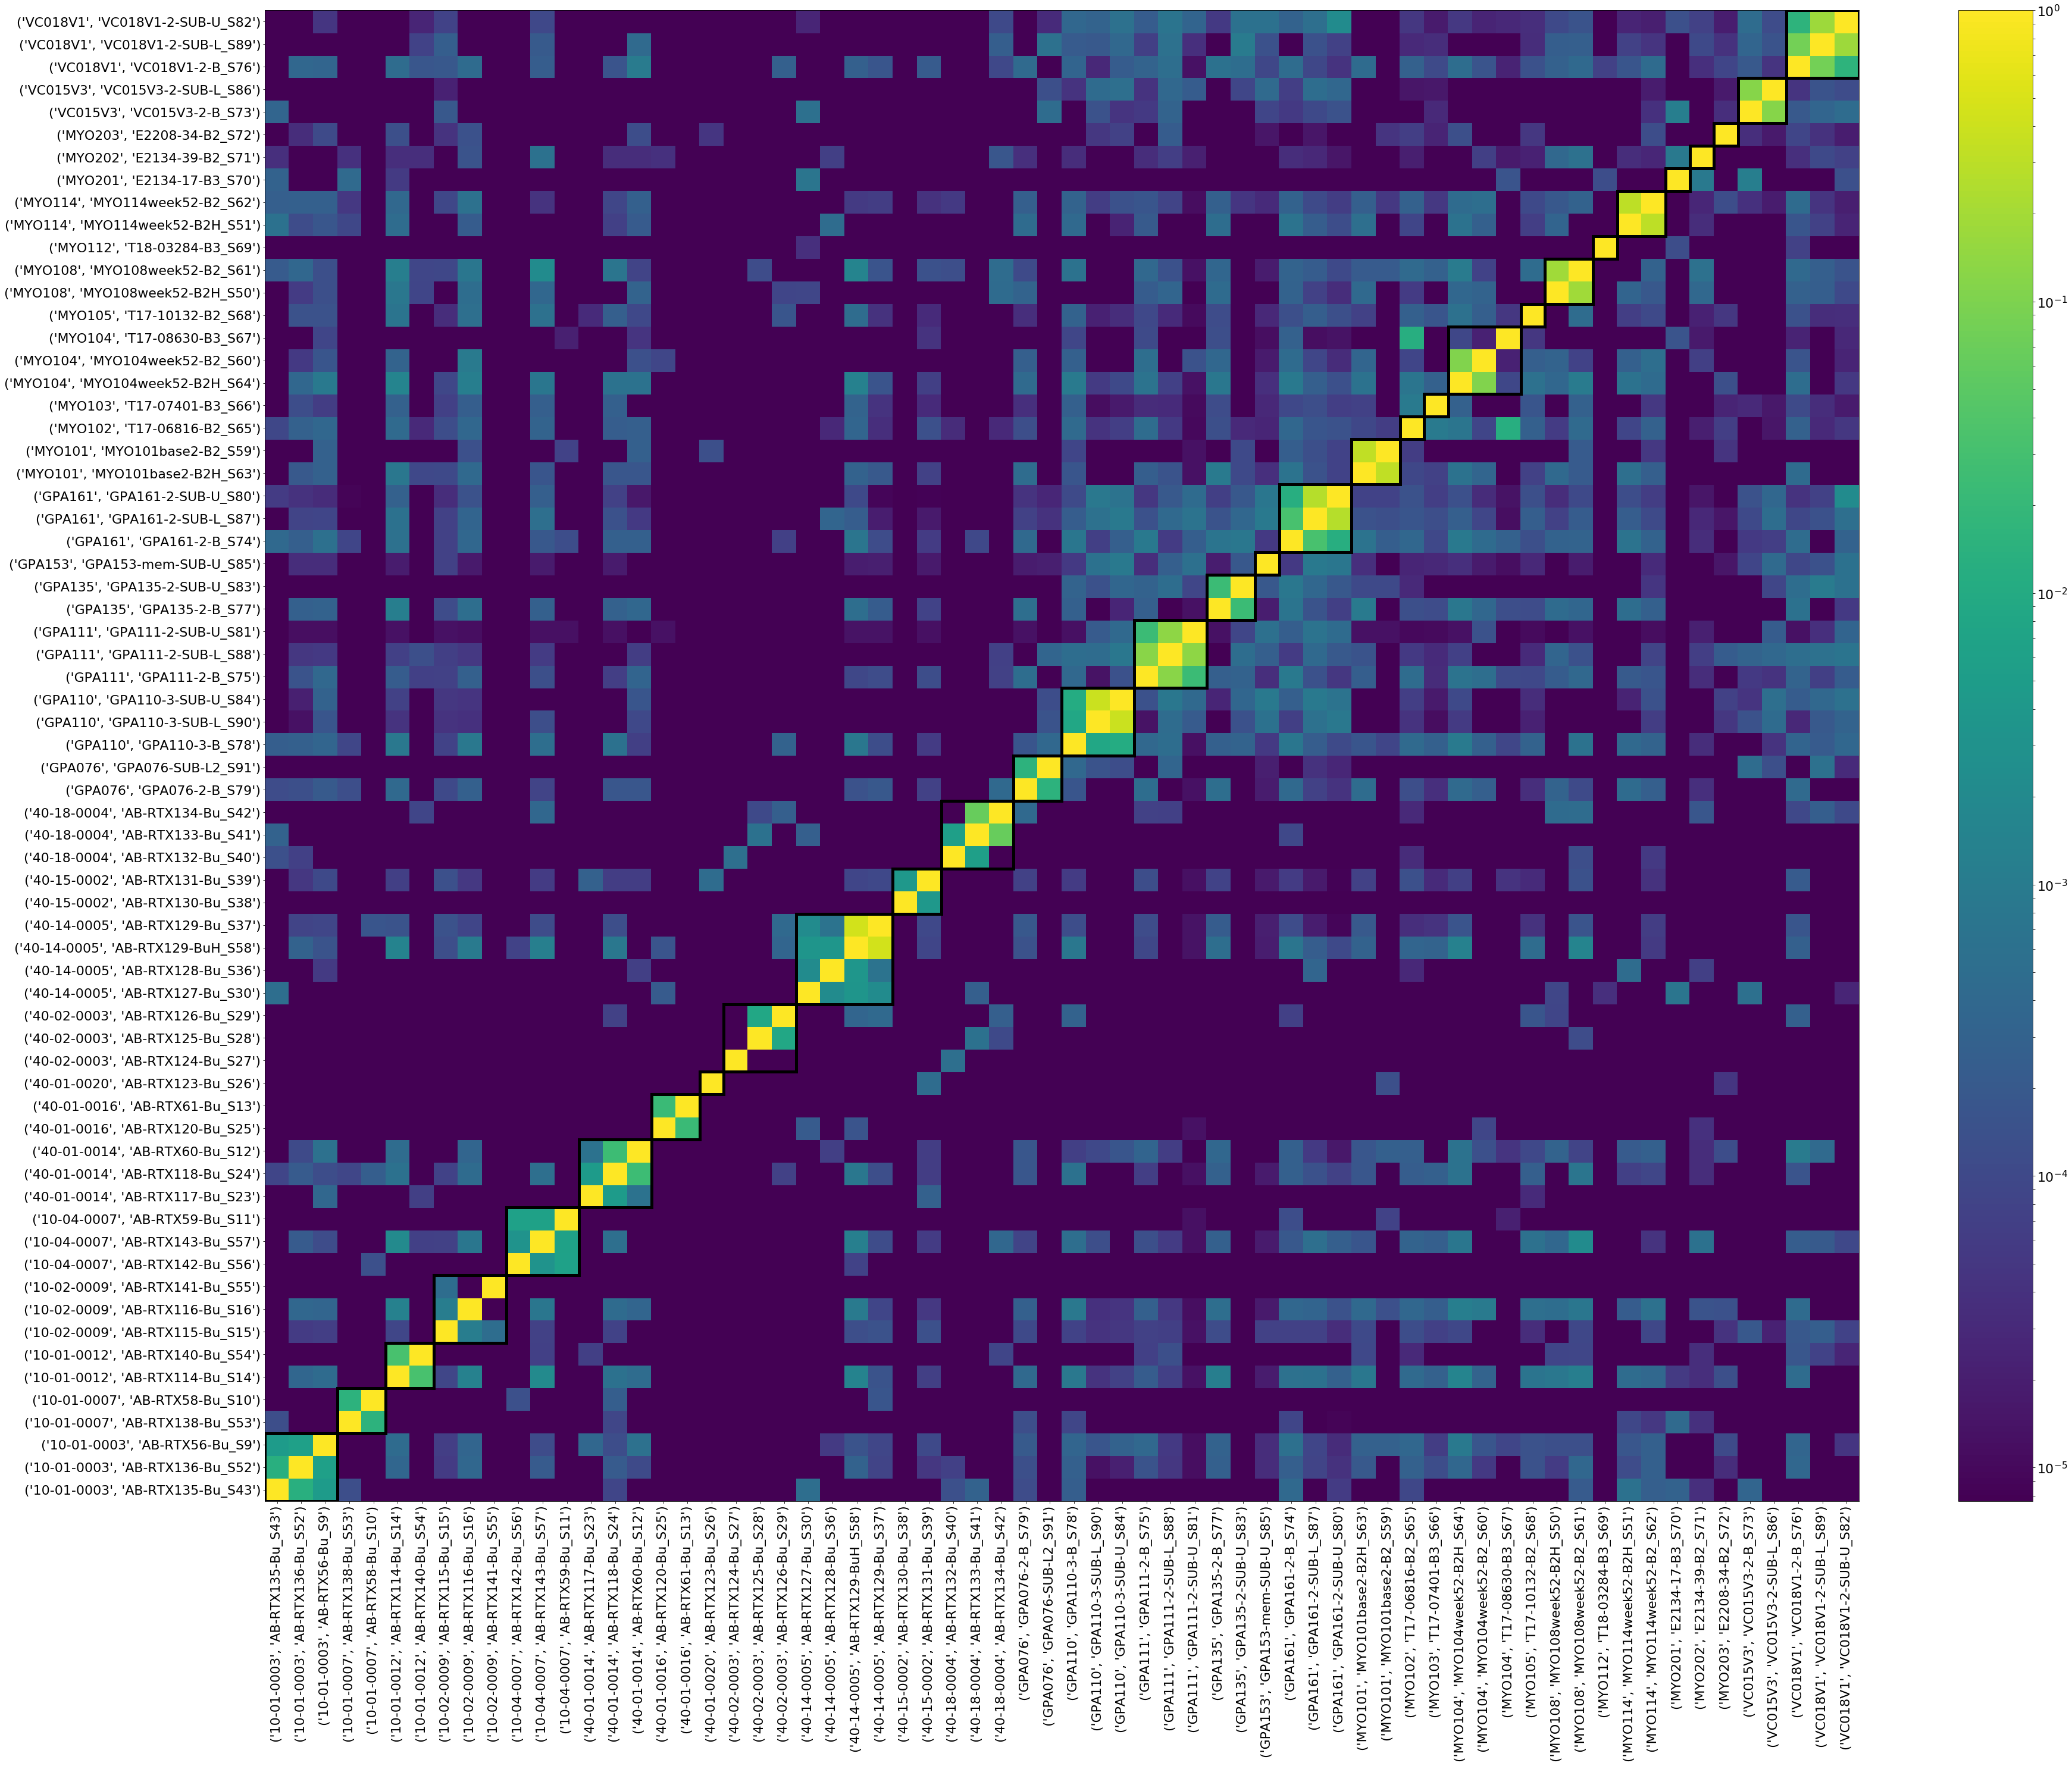

In [16]:
drawHeatmap(sim)

## Highlight anomalies

In [17]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [18]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.06224988062544286 0.1086840736333873
mean diff patient 9.855712222289642e-05 0.00033702376814028374
threshold 0.0014466521947840314


{'whiskers': [<matplotlib.lines.Line2D at 0x7f43c2b70208>,
 'caps': [<matplotlib.lines.Line2D at 0x7f43c2b70ac8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f43c2b700b8>,
 'medians': [<matplotlib.lines.Line2D at 0x7f43c2b3b358>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f43c2b3b780>,
 'means': []}

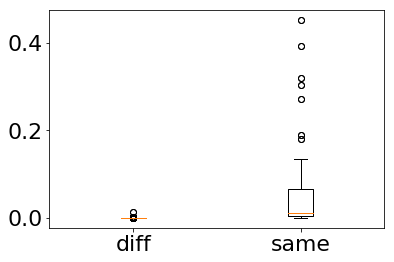

In [19]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

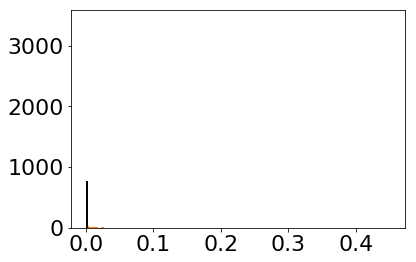

In [20]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [21]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

('10-01-0012', 'AB-RTX114-Bu_S14') ('10-04-0007', 'AB-RTX143-Bu_S57') 0.002042746358993708
('10-01-0012', 'AB-RTX114-Bu_S14') ('40-14-0005', 'AB-RTX129-BuH_S58') 0.0014876340420256762
('10-01-0012', 'AB-RTX114-Bu_S14') ('MYO104', 'MYO104week52-B2H_S64') 0.0015839001211217507
('10-04-0007', 'AB-RTX143-Bu_S57') ('10-01-0012', 'AB-RTX114-Bu_S14') 0.002042746358993708
('10-04-0007', 'AB-RTX143-Bu_S57') ('MYO108', 'MYO108week52-B2_S61') 0.0021203910943573545
('40-14-0005', 'AB-RTX129-BuH_S58') ('10-01-0012', 'AB-RTX114-Bu_S14') 0.0014876340420256762
('40-14-0005', 'AB-RTX129-BuH_S58') ('MYO108', 'MYO108week52-B2_S61') 0.001582591493570762
('GPA161', 'GPA161-2-SUB-U_S80') ('VC018V1', 'VC018V1-2-SUB-U_S82') 0.0021768407565210257
('MYO102', 'T17-06816-B2_S65') ('MYO104', 'T17-08630-B3_S67') 0.012482759152097067
('MYO104', 'MYO104week52-B2H_S64') ('10-01-0012', 'AB-RTX114-Bu_S14') 0.0015839001211217507
('MYO104', 'T17-08630-B3_S67') ('MYO102', 'T17-06816-B2_S65') 0.012482759152097067
('MYO108',

In [22]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 7.668153010342849e-06
max value: 1.0
Wrote run39-similarity-IGH_HUMAN-highlighted.pdf to disk


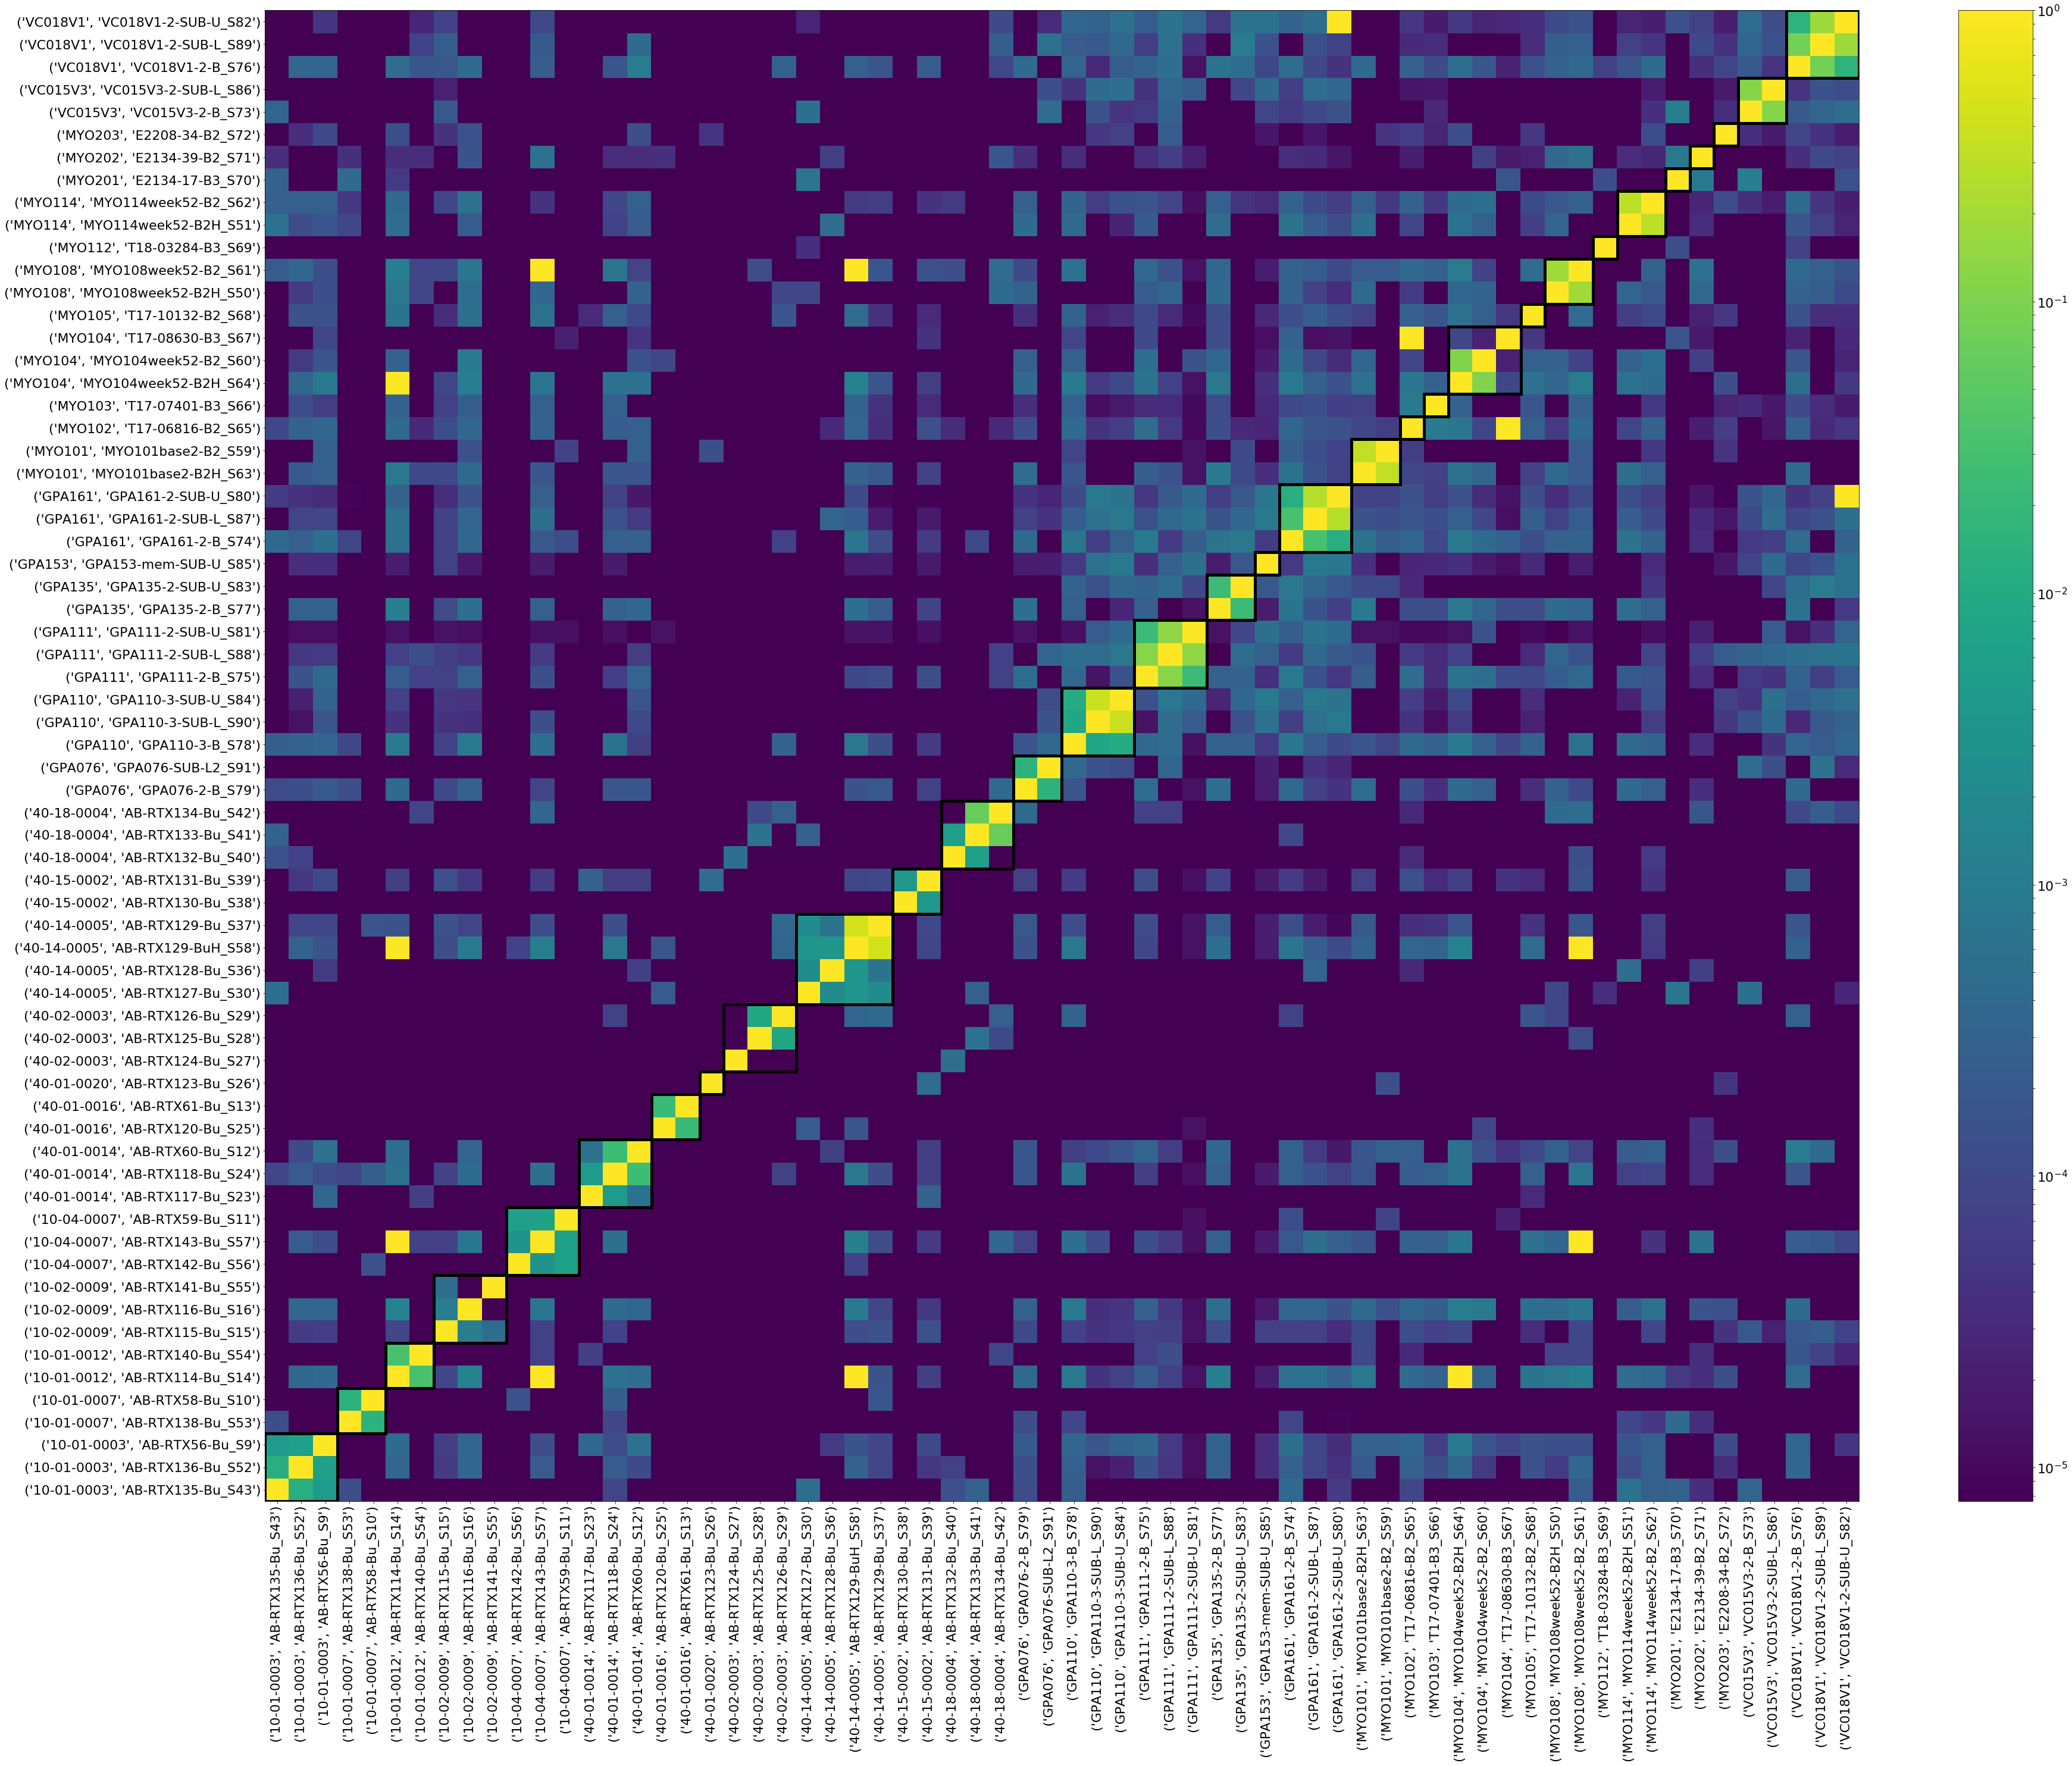

In [23]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)